### --------------------All the imports come here --------------

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import os
from PIL import Image
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import numpy as np


## Data Loader

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, data_dir, transform=None, label_transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.label_transform = label_transform

        self.image_files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        label_image = copy.deepcopy(image)

        if self.transform:
            image = self.transform(image)
        if self.label_transform:
            label_image = self.label_transform(label_image)

        return image, label_image

# Preprocessing steps
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

label_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
train_data_dir = '/kaggle/input/isic-dataset/Train_data/Train_data'
train_dataset = ISICDataset(data_dir=train_data_dir, transform=data_transform, label_transform=label_transform)

# Create DataLoader for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda")

# Use a small subset for quick testing
small_subset = torch.utils.data.Subset(train_dataset, range(100))
subset_loader = DataLoader(small_subset, batch_size=batch_size, shuffle=True)

# Information about the subset and the device
print(f"Number of batches in the subset: {len(subset_loader)}.")
print(f"Using {'GPU' if device.type == 'cuda' else 'CPU'} for training.")


Number of batches in the subset: 4.
Using GPU for training.


### Visualizations

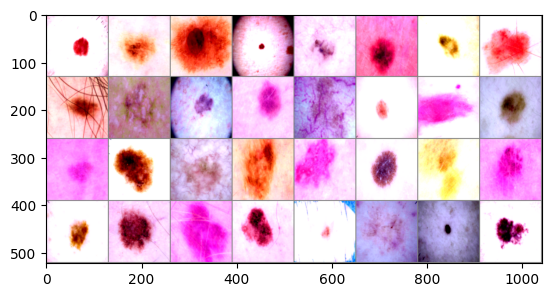

In [ ]:
# Function to denormalize image for visualization
def imshow(img):
    img = img / 2 + 0.5
    img = np.clip(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Assuming subset_loader is your DataLoader object
dataiter = iter(subset_loader)
images, labels = next(dataiter)

# Show images in a grid
imshow(torchvision.utils.make_grid(images))

## -------------- Encoder Architecture ---------------

In [ ]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_channels, feature_maps):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, feature_maps, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(feature_maps)
        self.conv2 = nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(feature_maps * 2)
        self.conv3 = nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(feature_maps * 4)
        self.conv4 = nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(feature_maps * 8)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        return x

encoder = Encoder(input_channels=3, feature_maps=16)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)

images, labels = next(iter(subset_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    encoded_images = encoder(images)

print(f'Shape of the encoded images: {encoded_images.size()}')

Shape of the encoded images: torch.Size([32, 128, 8, 8])


## Vector Quantizer Layer

In [ ]:
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1.0 / num_embeddings, 1.0 / num_embeddings)

    def forward(self, inputs):
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(flat_input, self.embeddings.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantized latent vectors
        quantized = torch.matmul(encodings, self.embeddings.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        return quantized, loss, encoding_indices

vector_quantizer = VectorQuantizer(num_embeddings=512, embedding_dim=128, commitment_cost=0.25)

## Decoder Architecture

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_channels, feature_maps):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(feature_maps * 8, feature_maps * 2, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(feature_maps * 2)
        self.conv2 = nn.ConvTranspose2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(feature_maps * 4)
        self.conv3 = nn.ConvTranspose2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(feature_maps * 8)
        self.conv_final = nn.ConvTranspose2d(feature_maps * 8, output_channels, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.sigmoid(self.conv_final(x))
        return x

## Integrating

In [ ]:
class VQVAE(nn.Module):
    def __init__(self, input_channels, feature_maps, num_embeddings, embedding_dim, commitment_cost):
        super(VQVAE, self).__init__()

        self.encoder = Encoder(input_channels=input_channels, feature_maps=feature_maps)

        self.quantizer = VectorQuantizer(num_embeddings=num_embeddings, embedding_dim=embedding_dim, commitment_cost=commitment_cost)

        self.decoder = Decoder(feature_maps=feature_maps, output_channels=input_channels)

    def forward(self, x):
        z = self.encoder(x)
        quantized, quantization_loss, encoding_indices = self.quantizer(z)
        x_recon = self.decoder(quantized)
        return x_recon, quantization_loss, encoding_indices


## Instantiating

In [ ]:
# Define hyperparameters
input_channels = 3
feature_maps = 16
num_embeddings = 512
embedding_dim = 128
commitment_cost = 0.25

# Instantiate the model
vqvae_model = VQVAE(input_channels, feature_maps, num_embeddings, embedding_dim, commitment_cost)
vqvae_model.to(device)


VQVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (quantizer): VectorQuantizer(
    (embeddings): Embedding(512, 128)
  )
  (decoder): Decoder(
    (conv1): ConvTranspose2d(128, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_sta

## Loss function

In [ ]:
import torch.optim as optim

def vqvae_loss(reconstructed, original, quantization_loss):
    recon_loss = F.mse_loss(reconstructed, original)
    return recon_loss + quantization_loss


## Optimizer

In [ ]:
optimizer = optim.Adam(vqvae_model.parameters(), lr=0.005)

## Visualize Images during training

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(original, inputs, reconstructed, n=10):
    original = original.to('cpu').detach().numpy()
    inputs = inputs.to('cpu').detach().numpy()
    reconstructed = reconstructed.to('cpu').detach().numpy()

    original = (original - np.min(original)) / (np.max(original) - np.min(original)) * 255
    inputs = (inputs - np.min(inputs)) / (np.max(inputs) - np.min(inputs)) * 255
    reconstructed = (reconstructed - np.min(reconstructed)) / (np.max(reconstructed) - np.min(reconstructed)) * 255

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Display original images
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(np.uint8(original[i].transpose(1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display input images
        ax = plt.subplot(3, n, n + i + 1)
        plt.imshow(np.uint8(inputs[i].transpose(1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed images
        ax = plt.subplot(3, n, 2 * n + i + 1)
        plt.imshow(np.uint8(reconstructed[i].transpose(1, 2, 0)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


## Checkpoint:

In [ ]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

## Load - checkpoint

In [ ]:
def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']
    return start_epoch


## Training Loop:


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_codebook_usage(encoding_indices, num_embeddings):
    indices = encoding_indices.flatten()
    histogram, bins = np.histogram(indices.cpu().numpy(), bins=np.arange(num_embeddings + 1))
    plt.figure(figsize=(10, 4))
    plt.bar(bins[:-1], histogram, width=0.8, align='center')
    plt.title("Histogram of Codebook Vector Usage")
    plt.xlabel("Codebook Index")
    plt.ylabel("Frequency of Usage")
    plt.show()

def analyze_sparsity(encoding_indices, num_embeddings):
    unique_indices = torch.unique(encoding_indices)
    print(f'Total embeddings used: {len(unique_indices)}/{num_embeddings}')
    if len(unique_indices) < num_embeddings:
        print("Some embeddings are never used:")
        print(set(range(num_embeddings)) - set(unique_indices.tolist()))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: divyaansh. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240501_164654-ka6gvbfh
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eternal-disco-31
wandb: ⭐️ View project at https://wandb.ai/divyaansh/DL_Assignment_5
wandb: 🚀 View run at https://wandb.ai/divyaansh/DL_Assignment_5/runs/ka6gvbfh
282it [03:49,  1.23it/s]


Epoch 1, Average Loss: 0.6645278823925248


282it [02:39,  1.77it/s]


Epoch 2, Average Loss: 0.31139600815925195


282it [02:43,  1.73it/s]


Epoch 3, Average Loss: 0.29859917949066095


282it [02:45,  1.70it/s]


Epoch 4, Average Loss: 0.2760878878493681


282it [02:42,  1.74it/s]


Epoch 5, Average Loss: 0.2641070548524248


282it [02:39,  1.77it/s]


Epoch 6, Average Loss: 0.2637485161635047


282it [02:35,  1.81it/s]


Epoch 7, Average Loss: 0.2598292266434811


282it [02:36,  1.80it/s]


Epoch 8, Average Loss: 0.25570813127866027


282it [02:38,  1.78it/s]


Epoch 9, Average Loss: 0.25472750990314685


282it [02:39,  1.77it/s]


Epoch 10, Average Loss: 0.2526101458896982
Visualizing Reconstructed Images - Epoch 10


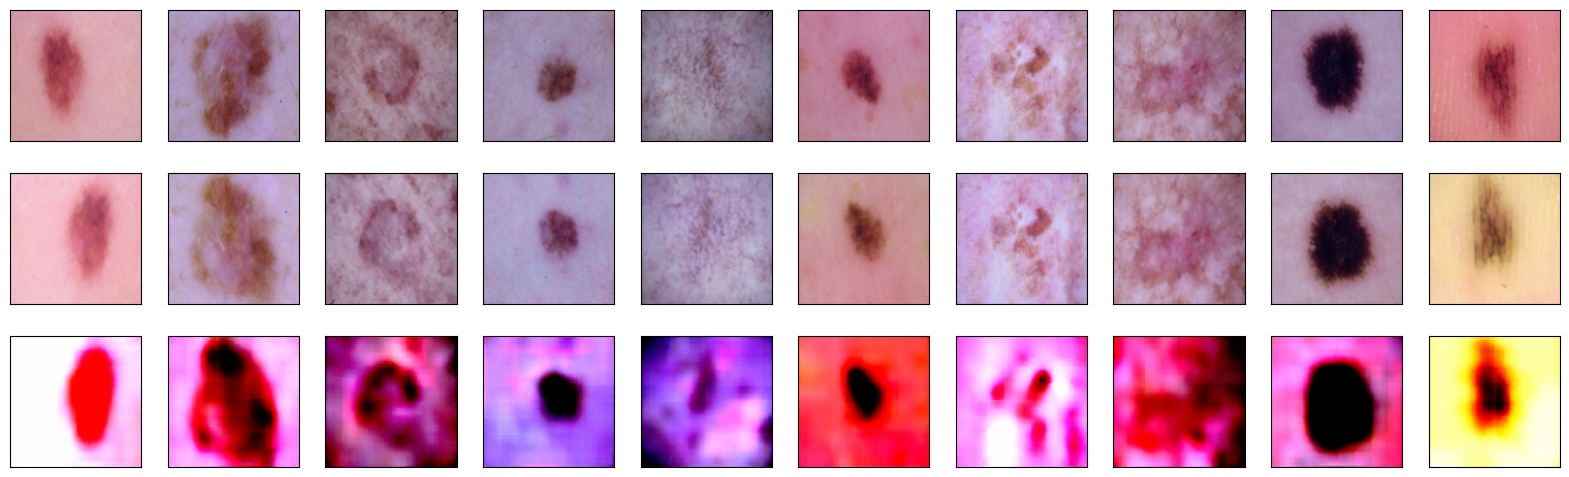

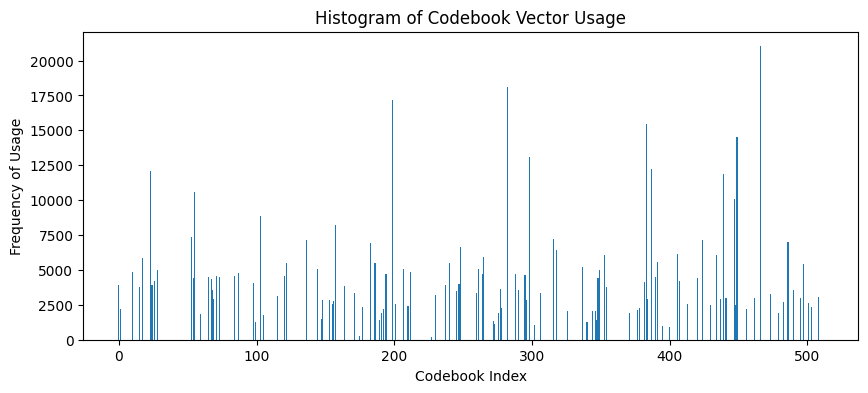

Total embeddings used: 126/512
Some embeddings are never used:
{2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 56, 57, 58, 60, 61, 62, 63, 64, 66, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 121, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 145, 146, 149, 150, 151, 152, 154, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 172, 173, 174, 176, 178, 179, 180, 181, 182, 184, 185, 187, 188, 190, 193, 195, 196, 197, 198, 200, 202, 203, 204, 205, 206, 208, 209, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 228, 229, 231, 232, 233, 234, 235, 236, 238, 239, 241, 242, 243, 244, 246, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 262, 263, 266, 

98it [00:56,  1.75it/s]wandb: Network error (ReadTimeout), entering retry loop.
282it [02:40,  1.75it/s]


Epoch 11, Average Loss: 0.2527387500443357


282it [02:42,  1.74it/s]


Epoch 12, Average Loss: 0.25153257697820663


282it [02:44,  1.71it/s]


Epoch 13, Average Loss: 0.250103789229765


282it [02:42,  1.74it/s]


Epoch 14, Average Loss: 0.25004291360048536


282it [02:45,  1.71it/s]


Epoch 15, Average Loss: 0.25019731922141203


282it [02:44,  1.72it/s]


Epoch 16, Average Loss: 0.25140456015125234


282it [02:42,  1.74it/s]


Epoch 17, Average Loss: 0.24990167194013055


282it [02:44,  1.72it/s]


Epoch 18, Average Loss: 0.24774584168872088


282it [02:41,  1.74it/s]


Epoch 19, Average Loss: 0.25016284237305325


282it [02:41,  1.75it/s]


Epoch 20, Average Loss: 0.2494983781948157
Visualizing Reconstructed Images - Epoch 20


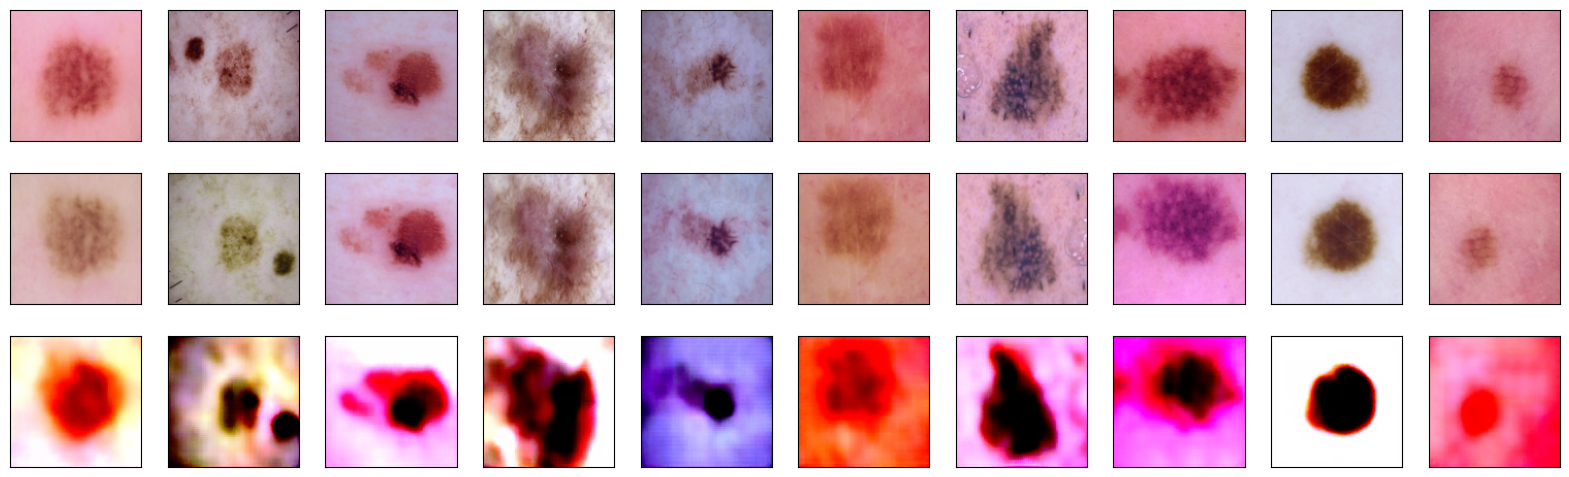

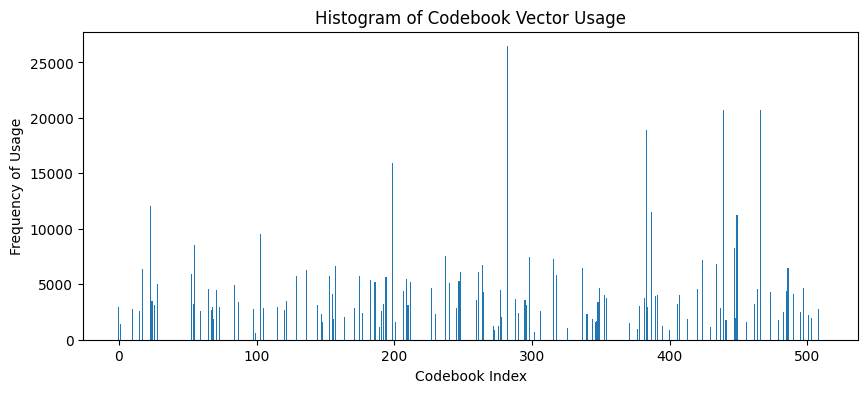

Total embeddings used: 129/512
Some embeddings are never used:
{2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 56, 57, 58, 60, 61, 62, 63, 64, 66, 70, 72, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 100, 101, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 121, 123, 124, 125, 126, 127, 128, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 145, 146, 149, 150, 151, 152, 154, 158, 159, 160, 161, 162, 163, 165, 166, 167, 168, 169, 170, 172, 173, 174, 176, 178, 179, 180, 181, 182, 184, 185, 187, 188, 190, 193, 195, 196, 197, 198, 200, 202, 203, 204, 205, 206, 208, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 228, 229, 231, 232, 233, 234, 235, 236, 238, 239, 241, 242, 243, 244, 246, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 262, 263, 266, 267, 268, 

wandb:                                                                                
wandb: 
wandb: Run history:
wandb: batch_loss █▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▁▂▁▂▂▂▂▁▂▂▁▂▁▁▂▂▁▂▂▁▁▂
wandb: epoch_loss █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb: batch_loss 0.28309
wandb: epoch_loss 0.2495
wandb: 
wandb: 🚀 View run eternal-disco-31 at: https://wandb.ai/divyaansh/DL_Assignment_5/runs/ka6gvbfh
wandb: ⭐️ View project at: https://wandb.ai/divyaansh/DL_Assignment_5
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240501_164654-ka6gvbfh/logs


In [ ]:
import wandb
torch.autograd.set_detect_anomaly(True)

def train_vqvae(model, data_loader, optimizer, num_epochs, num_embeddings, device):
    wandb.login(key='cda5ad4d537ea48e73ee63632ace57eb0b75c454')
    wandb.init(project='DL_Assignment_5', entity='divyaansh', config={
        "num_epochs": num_epochs,
        "num_embeddings": num_embeddings
    })


    model.train()

    checkpoint_path = None
    start_epoch = 0
    if checkpoint_path:
        start_epoch = load_checkpoint(checkpoint_path, model, optimizer)

    for epoch in range(start_epoch, num_epochs):
        total_loss = 0
        encoding_indices_list = []

        for batch_idx, data in tqdm(enumerate(data_loader)):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            reconstructed_images, quantization_loss, encoding_indices = model(images)
            loss = vqvae_loss(reconstructed_images, images, quantization_loss)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            encoding_indices_list.append(encoding_indices.detach().cpu())

            # Log batch level metrics
            wandb.log({"batch_loss": loss.item()})

        epoch_loss = total_loss / len(data_loader)
        all_encoding_indices = torch.cat(encoding_indices_list, dim=0)
        print(f'Epoch {epoch + 1}, Average Loss: {epoch_loss}')

        # Log epoch level metrics
        wandb.log({"epoch_loss": epoch_loss})

        if (epoch + 1) % 10 == 0:
            print(f"Visualizing Reconstructed Images - Epoch {epoch + 1}")
            show_images(labels[:10], images[:10], reconstructed_images[:10])
            plot_codebook_usage(all_encoding_indices, num_embeddings)
            analyze_sparsity(all_encoding_indices, num_embeddings)
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, "vqvae_checkpoint.pth")

    return all_encoding_indices

num_epochs = 20
num_embeddings = 512
all_encoding_indices = train_vqvae(vqvae_model, train_loader, optimizer, num_epochs, num_embeddings, device)
wandb.finish()

## Indices

In [ ]:
all_encoding_indices = all_encoding_indices.reshape(9015, 8, 8)
print("Shape of encoding indices:", all_encoding_indices.shape)

Shape of encoding indices: torch.Size([9015, 8, 8])


In [ ]:
class IndicesDataset(Dataset):
    def __init__(self, indices):
        self.indices = torch.tensor(indices, dtype=torch.long)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.indices[idx]

indices_dataset = IndicesDataset(all_encoding_indices)
indices_loader = DataLoader(indices_dataset, batch_size=32, shuffle=True)


/tmp/ipykernel_25/4231326541.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.indices = torch.tensor(indices, dtype=torch.long)


In [ ]:
sample_indices = next(iter(indices_loader))
print("Sample batch shape from DataLoader:", sample_indices.shape)
print("Sample data:", sample_indices[:1])


Sample batch shape from DataLoader: torch.Size([32, 8, 8])
Sample data: tensor([[[210, 383, 466, 466, 383, 103,  23, 260],
         [199, 383, 466, 466, 383, 466,  23,  55],
         [383, 466, 466, 449, 449, 466, 383,  53],
         [383, 466, 449, 479, 316, 318, 466,  23],
         [199, 466, 282, 183, 501, 282, 466,  23],
         [ 23, 383, 466, 282, 282, 466, 383,  23],
         [ 23, 383, 466, 466, 466, 466, 383,  53],
         [ 53,  23, 383, 466, 466, 466, 383, 122]]])


## Auto REgressive Model (PixelCNN)

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        self.register_buffer('mask', self.weight.data.clone())
        _, _, height, width = self.weight.size()
        self.mask.fill_(1)
        if mask_type == 'A':
            self.mask[:, :, height // 2, width // 2:] = 0
            self.mask[:, :, height // 2 + 1:] = 0
        else:
            self.mask[:, :, height // 2, width // 2 + 1:] = 0
            self.mask[:, :, height // 2 + 1:] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class PixelCNN(nn.Module):
    def __init__(self, num_embeddings, embedding_dim=64, num_layers=6, kernel_size=7):
        super(PixelCNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(MaskedConv2d('A', 1, embedding_dim, kernel_size, padding=kernel_size//2))
        self.layers.append(nn.ReLU())

        for _ in range(num_layers - 1):
            self.layers.append(MaskedConv2d('B', embedding_dim, embedding_dim, kernel_size, padding=kernel_size//2))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Conv2d(embedding_dim, num_embeddings, 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
from torch.optim import Adam

# Parameters
num_embeddings = 512
embedding_dim = 128
num_epochs = 200

# Initialize the model and optimizer
pixelcnn_model = PixelCNN(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pixelcnn_model.parameters(), lr=0.001)
pixelcnn_model.to(device)

PixelCNN(
  (layers): ModuleList(
    (0): MaskedConv2d(1, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (3): ReLU()
    (4): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (5): ReLU()
    (6): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (9): ReLU()
    (10): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (11): ReLU()
    (12): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
wandb.login(key='cda5ad4d537ea48e73ee63632ace57eb0b75c454')
wandb.init(project='DL_Assignment_5', entity='divyaansh', config={
    "num_epochs": num_epochs,
    "num_embeddings": num_embeddings
})
for epoch in range(num_epochs):
    for batch_idx, inputs in enumerate(indices_loader):
        inputs = inputs.unsqueeze(1).to(device).float()

        optimizer.zero_grad()
        outputs = pixelcnn_model(inputs)
        outputs = outputs.permute(0, 2, 3, 1).contiguous().view(-1, num_embeddings)
        labels = inputs.squeeze(1).view(-1).long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            wandb.log({"Loss": loss.item()})
            print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}")
    if (epoch + 1) % 10 == 0:
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': pixelcnn_model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, "pixelcnn_checkpoint.pth")
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240501_174233-cizex11e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run leafy-valley-32
wandb: ⭐️ View project at https://wandb.ai/divyaansh/DL_Assignment_5
wandb: 🚀 View run at https://wandb.ai/divyaansh/DL_Assignment_5/runs/cizex11e


Epoch: 0, Batch: 0, Loss: 6.238409996032715
Epoch: 0, Batch: 100, Loss: 4.523623943328857
Epoch: 0, Batch: 200, Loss: 4.54387903213501
Epoch: 1, Batch: 0, Loss: 4.449326992034912
Epoch: 1, Batch: 100, Loss: 4.279681205749512
Epoch: 1, Batch: 200, Loss: 4.244065284729004
Epoch: 2, Batch: 0, Loss: 4.372107028961182
Epoch: 2, Batch: 100, Loss: 4.233274936676025
Epoch: 2, Batch: 200, Loss: 4.458995819091797
Epoch: 3, Batch: 0, Loss: 4.29494571685791
Epoch: 3, Batch: 100, Loss: 4.561919212341309
Epoch: 3, Batch: 200, Loss: 4.356852054595947
Epoch: 4, Batch: 0, Loss: 4.333833694458008
Epoch: 4, Batch: 100, Loss: 4.387673377990723
Epoch: 4, Batch: 200, Loss: 4.412453651428223
Epoch: 5, Batch: 0, Loss: 4.061567306518555
Epoch: 5, Batch: 100, Loss: 4.382569789886475
Epoch: 5, Batch: 200, Loss: 4.276115417480469
Epoch: 6, Batch: 0, Loss: 4.200279235839844
Epoch: 6, Batch: 100, Loss: 4.273575782775879
Epoch: 6, Batch: 200, Loss: 4.122272491455078
Epoch: 7, Batch: 0, Loss: 4.074337005615234
Epoch:

wandb:                                                                                
wandb: 
wandb: Run history:
wandb: Loss █▇██▆▆▄▅▄▅▄▄▃▃▂▂▂▃▂▂▂▂▂▃▂▂▂▁▂▂▂▁▁▂▂▂▁▁▁▂
wandb: 
wandb: Run summary:
wandb: Loss 2.33302
wandb: 
wandb: 🚀 View run leafy-valley-32 at: https://wandb.ai/divyaansh/DL_Assignment_5/runs/cizex11e
wandb: ⭐️ View project at: https://wandb.ai/divyaansh/DL_Assignment_5
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240501_174233-cizex11e/logs


In [ ]:
def generate_indices_matrix(model, device, side_length=8, n=10):
    indices_matrices = []
    for i in range(n):
        indices_matrix = torch.zeros((1, 1, side_length, side_length), dtype=torch.long, device=device)
        for i in range(side_length):
            for j in range(side_length):
                logits = model(indices_matrix.float())
                probabilities = torch.softmax(logits[:, :, i, j], dim=-1)
                new_index = torch.multinomial(probabilities, num_samples=1)
                indices_matrix[:, :, i, j] = new_index
        indices_matrices.append(indices_matrix.squeeze().to(torch.device(device)).reshape(64,1))
    return(indices_matrices)

In [ ]:
n = 10
incides_matrices = generate_indices_matrix(pixelcnn_model, device, 8, 10)

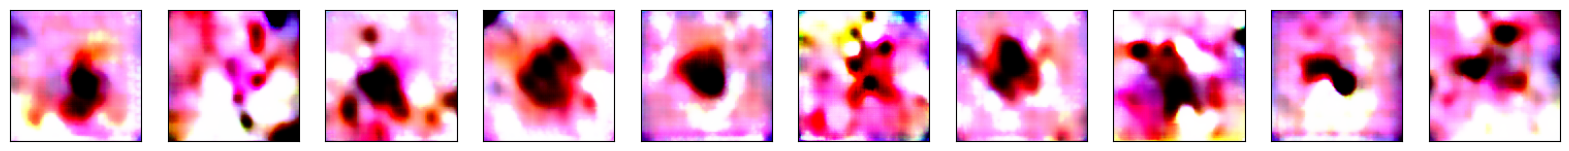

In [ ]:
plt.figure(figsize=(20, 6))
for i in range(n):
    encodings = torch.zeros(incides_matrices[i].shape[0], num_embeddings, device=inputs.device)
    encodings.scatter_(1, incides_matrices[i], 1)

    quantized = torch.matmul(encodings, vqvae_model.quantizer.embeddings.weight).view([1,8,8,128]).detach()

    quantized = quantized.permute(0, 3, 1, 2).contiguous()
    reconstructed = vqvae_model.decoder(quantized)

    reconstructed = reconstructed.to('cpu').detach().numpy()
    reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min()) * 255
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(np.uint8(reconstructed.squeeze()).transpose(1, 2, 0))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)